## Forecasting USD - MXN Exchange Rate

Se presentan tres modelos de **pronóstico** del tipo de cambio de *Dólar Americano (USD)* a *Peso Mexicano (MXN)*, por medio de los siguientes enfoques:

- Modelo Mínimos Cuadrados Ordinario - Regresión.
- Modelo Autoregresivo de Series de Tiempo.
- Modelo Autoregresivo de Series de Tiempo con Variables Exógenas.

El modelo de **Regresión por Mínimos Cuadraros Ordinarios** se busca modelar:

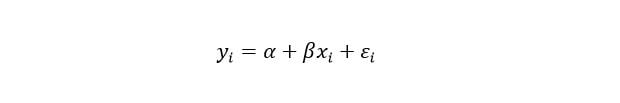

con parámetros dados por:

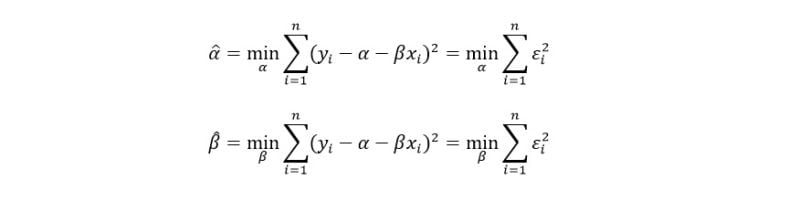

Los modelos de **Series Temporales** son una descomposición aditiva / multiplicativa, en la que se identifican y separan tres componentes principales de la serie temporal:

- Tendencia (Trend).
- Estacionalidad (Seasonality).
- Eventos Excepcionales (Vacations / Holidays / Events).
- Residuos (Noise).

La presencia del componente de tendencia permite manejar evoluciones de largo plazo, mientras que la estacionalidad ayuda a capturar variaciones periódicas.

El objetivo es identificar los patrones de correlación temporal que permitan transformar la serie temporal en una serie *estacionaria* en la que puede ajustarse un modelo estadístico.

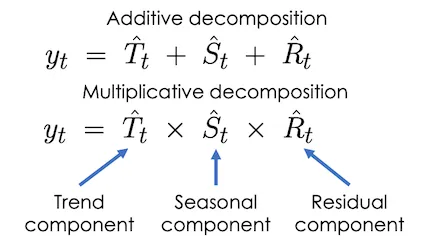


La información de la tasa de cambio, así como de los regresores exógenos son obtenidos del **Banco de Datos del Banco Mundial** (https://databank.worldbank.org/)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric

### Dataset

El siguiente conjunto de datos se obtuvo por medio del **Banco de Datos** del *Banco Mundial* (http://databank.worldbank.org/data/reports.aspx?source=2&series=PA.NUS.FCRF&country=) e incluye la siguiente consulta sobre indicadores macroeconómicos anualizados de México de los últimos **30 años**:

- Official exchange rate (LCU per US$, period average)
- GDP growth (annual %)
- Inflation, consumer prices (annual %)
- Current account balance (% of GDP)
- Unemployment, total (% of total labor force) (national estimate)
- Lending interest rate (%)
- Merchandise Trade (%) (sum of merchandise exports and imports divided by the value of GDP).

Obtenidos de la base de datos *World Development Indicators* actualizada el 28/Junio/2024


In [2]:
# .csv Global Key Indicators
mx_df = pd.read_csv("EXMXUS_MULTIVAR.csv")
mx_df['Date'] = pd.to_datetime(mx_df['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df

,Year,Exchange Rate,GDP,Inflation,Balance,Unemployment,Interest Rate,Merchandise Trade,Date
0,1993,3.115617,2.866999,9.751460,-4.413756,3.365,18.225000,22.527695,1993-12-31
1,1994,3.375117,4.394128,6.965812,-5.357863,4.436,19.300000,25.806230,1994-12-31
2,1995,6.419425,-5.910300,34.999271,-0.414681,7.095,59.431667,40.501374,1995-12-31
3,1996,7.599448,6.218297,34.378383,-0.580285,5.465,36.385833,43.497754,1996-12-31
4,1997,7.918460,7.198876,20.625629,-1.464313,4.235,22.140000,42.707460,1997-12-31
5,1998,9.136042,6.185079,15.928395,-2.868838,3.733,26.358333,44.224072,1998-12-31
6,1999,9.560398,2.755030,16.585617,-2.217782,2.598,23.742500,44.748560,1999-12-31
7,2000,9.455558,5.029284,9.491561,-2.527072,2.646,16.928333,46.604099,2000-12-31
8,2001,9.342342,-0.450845,6.367738,-2.230034,2.627,12.795000,41.653153,2001-12-31
9,2002,9.655958,-0.236588,5.030727,-1.529365,3.003,8.210833,41.172191,2002-12-31


In [3]:
# .csv Global Key Indicators Forecasts from EIU
mx_df_ext = pd.read_csv("EXREGR.csv")
mx_df_ext['Date'] = pd.to_datetime(mx_df_ext['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df_ext

,Year,GDP,Inflation,Balance,Unemployment,Interest Rate,Merchandise Trade,Date
0,2024,2.3,4.4,-0.4,3.0,11.2,67.89,2024-12-31
1,2025,2.3,3.6,-0.7,3.1,9.9,67.89,2025-12-31
2,2026,2.1,3.3,-1.1,3.3,8.8,67.89,2026-12-31
3,2027,2.2,3.2,-1.3,3.3,7.9,67.89,2027-12-31
4,2028,2.2,3.1,-1.6,3.3,7.6,67.89,2028-12-31


### Correlograma

<Axes: title={'center': 'USD - MXN Exchange Rate Correlogram'}>

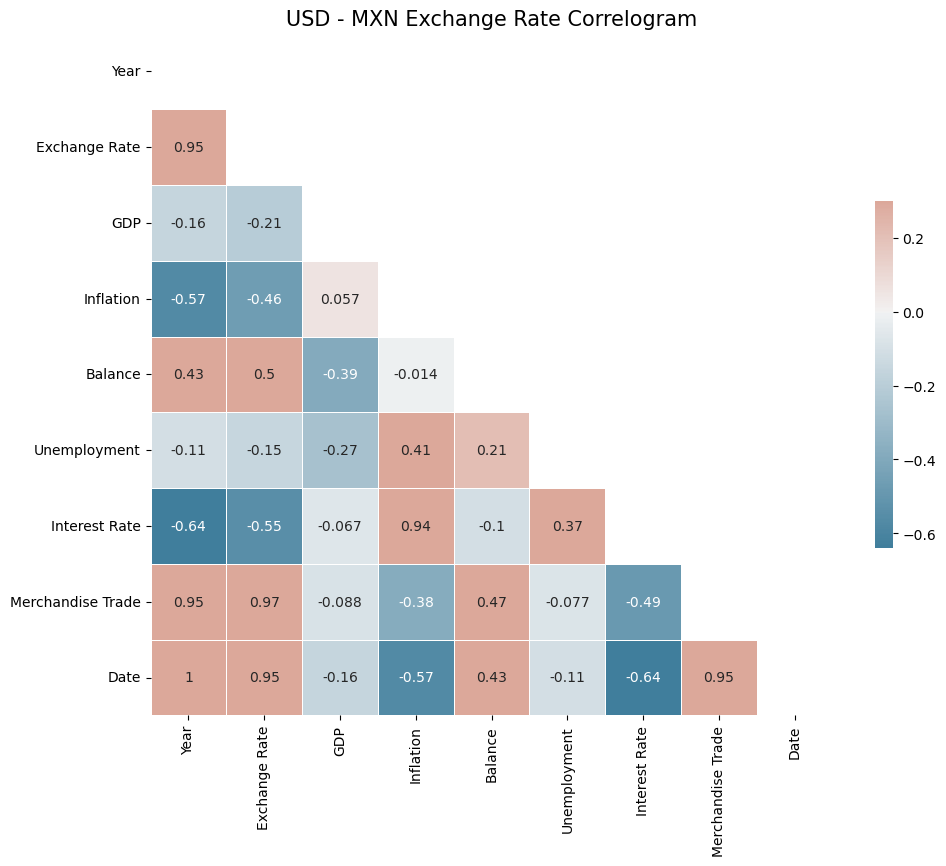

In [4]:
# Compute the correlation matrix
corr = mx_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title("USD - MXN Exchange Rate Correlogram",size=15)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

### OLS Regression

In [5]:
# Train - Test Split
mx_df_train = mx_df.iloc[:26,:]
mx_df_test = mx_df.iloc[26:,:]

# Multivariate OLS
#Q('Exchange Rate') ~ Year + Q('Interest Rate') + Balance + Inflation + GDP + Unemployment
OLS_model = smf.ols("Q('Exchange Rate') ~ Year + GDP + Q('Merchandise Trade')",data=mx_df).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q('Exchange Rate')   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     245.0
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           1.09e-19
Time:                        09:45:43   Log-Likelihood:                -41.074
No. Observations:                  31   AIC:                             90.15
Df Residuals:                      27   BIC:                             95.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -258.2481    129.051     -2.001      0.056    -523.038       6.542
Year                       0.1283      0.065      1.964      0.060      -0.006       0.262
GDP                       -0.1435      0.051     -2.796      0.009      -0.249      -0.038
Q('Merchandise Trade')     0.2510      0.041      6.155      0.000       0.167       0.335
==============================================================================
Omnibus:                        3.204   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                2.872
Skew:                          -0.712   Prob(JB):                        0.238
Kurtosis:                       2.555   Cond. No.                     1.48e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
# Generate Predictions
explanatories = ['Year','GDP','Merchandise Trade']
ex_hat_train = OLS_model.predict(mx_df_train[explanatories])
ex_hat_test = OLS_model.predict(mx_df_test[explanatories])
ex_hat = OLS_model.predict(mx_df[explanatories])

# Train Metrics
print("Train R2:",r2_score(mx_df_train['Exchange Rate'], ex_hat_train))
print("Train RMSE:",np.sqrt(mean_squared_error(mx_df_train['Exchange Rate'], ex_hat_train)))

# Test Metrics
print("Test R2:",r2_score(mx_df_test['Exchange Rate'], ex_hat_test))
print("Test RMSE:",np.sqrt(mean_squared_error(mx_df_test['Exchange Rate'], ex_hat_test)))

Train R2: 0.9460909290839881
Train RMSE: 0.9228868091416311
Test R2: 0.5351751421497829
Test RMSE: 0.841905345315757


Text(0.5, 1.0, 'USD - MXN Exchange Rate')

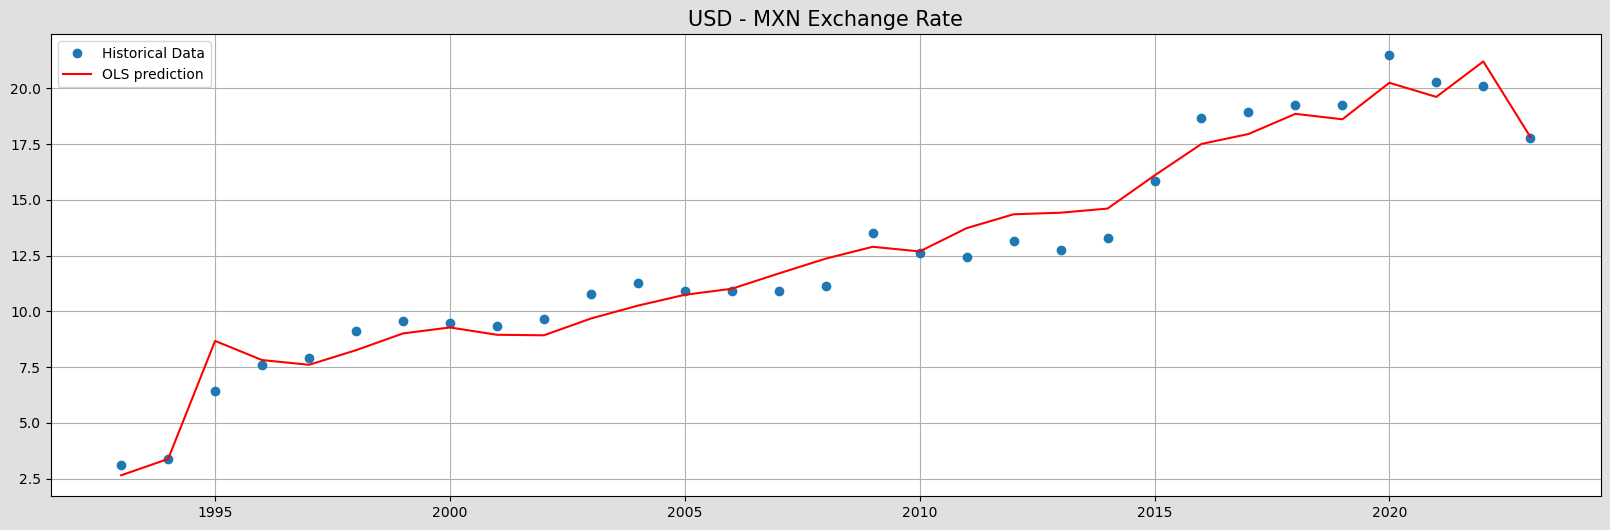

In [7]:
# Plot Predictions vs. Actuals
fig, ax = plt.subplots(figsize=(20,6))
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(mx_df['Year'], mx_df['Exchange Rate'], "o", label="Historical Data")
ax.plot(mx_df['Year'], ex_hat, "r", label="OLS prediction")
ax.legend(loc="best")
plt.title("USD - MXN Exchange Rate",size=15)

### Forecasting

In [8]:
ex_hat_forecast = pd.DataFrame(OLS_model.predict(mx_df_ext[explanatories]),columns=['Forecasted Exchange Rate'])
ex_hat_forecast = pd.concat([mx_df_ext,ex_hat_forecast],axis=1)
ex_hat_forecast

,Year,GDP,Inflation,Balance,Unemployment,Interest Rate,Merchandise Trade,Date,Forecasted Exchange Rate
0,2024,2.3,4.4,-0.4,3.0,11.2,67.89,2024-12-31,18.089197
1,2025,2.3,3.6,-0.7,3.1,9.9,67.89,2025-12-31,18.217471
2,2026,2.1,3.3,-1.1,3.3,8.8,67.89,2026-12-31,18.374439
3,2027,2.2,3.2,-1.3,3.3,7.9,67.89,2027-12-31,18.488367
4,2028,2.2,3.1,-1.6,3.3,7.6,67.89,2028-12-31,18.616641


### Modelo Serie Temporal Auto-Regresión

Se utiliza la librería Prophet para entrenar el modelo. Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.

In [9]:
# Preparing for Prophet
mx_df.rename(columns={'Exchange Rate':'y','Date':'ds'},inplace=True)

model = Prophet(interval_width = 0.95)
model.fit(mx_df)
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '365 days')
df_cv

09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing
09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing
09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing
09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing
09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:43 - cmdstanpy - INFO - Chain [1] done processing
09:45:43 - cmdstanpy - INFO - Chain [1] start processing
09:45:44 - cmdstanpy - INFO - Chain [1] done processing
09:45:44 - cmdstanpy - INFO - Chain [1] start processing
09:45:44 - cmdstanpy - INFO - Chain [1] done processing
09:45:44 - cmdstanpy - INFO - Chain [1] start processing
09:45:44 - cmdstanpy - INFO - Chain [1] done processing
09:45:44 - cmdstanpy - INFO - Chain [1] start processing
09:45:44 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-12-31,14.392383,12.152100,16.578879,13.292450,2014-01-02
1,2015-12-31,14.673805,12.682697,16.902086,15.848267,2015-01-02
2,2016-12-31,15.377350,13.324503,17.575818,18.664058,2016-01-02
3,2017-12-31,16.164749,13.879304,18.679007,18.926517,2017-01-01
4,2018-12-31,16.942102,14.324158,19.434969,19.244342,2018-01-01
5,2019-12-31,17.791461,15.285591,20.511063,19.263633,2019-01-01
6,2020-12-31,18.866496,16.405419,21.402280,21.485608,2020-01-01
7,2021-12-31,19.502192,16.763385,22.168712,20.272408,2020-12-31
8,2022-12-31,19.949494,17.398948,22.458401,20.127350,2021-12-31
9,2023-12-31,20.531400,17.899190,23.220509,17.758717,2022-12-31


#### Métricas de Validación Cruzada

In [10]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,363 days,1.294607,1.137808,1.137198,0.078428,0.078428,0.078210,1.0
1,364 days,6.474353,2.544475,2.455722,0.129518,0.132776,0.139302,0.5
2,365 days,3.793096,1.947587,1.584967,0.081215,0.079947,0.080561,0.5


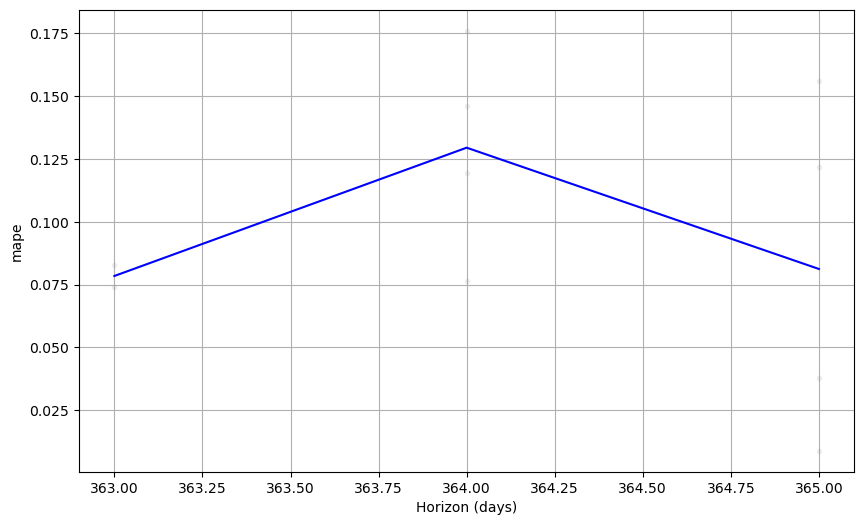

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    fig = plot_cross_validation_metric(df_cv, metric='mape')

Puede observarse que el horizonte de pronóstico con menor error es a **363 días** con un error porcentual del 7.8%

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado.

In [12]:
n_forecast = 5
future = model.make_future_dataframe(periods=n_forecast, freq='YE')
forecast = model.predict(future)
forecast.tail(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
32,2025-12-31,23.418899,18.600177,24.213713,23.418863,23.418933,-1.918733,-1.918733,-1.918733,-1.918733,-1.918733,-1.918733,0.0,0.0,0.0,21.500166
33,2026-12-31,23.935979,18.976231,24.452432,23.935918,23.936041,-2.215138,-2.215138,-2.215138,-2.215138,-2.215138,-2.215138,0.0,0.0,0.0,21.720841
34,2027-12-31,24.453059,19.498475,24.751816,24.452966,24.453156,-2.370346,-2.370346,-2.370346,-2.370346,-2.370346,-2.370346,0.0,0.0,0.0,22.082713
35,2028-12-31,24.971555,20.736043,26.295345,24.971432,24.971687,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,0.0,0.0,0.0,23.490062


In [13]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(4)

,ds,yhat,yhat_lower,yhat_upper
32,2025-12-31,21.500166,18.600177,24.213713
33,2026-12-31,21.720841,18.976231,24.452432
34,2027-12-31,22.082713,19.498475,24.751816
35,2028-12-31,23.490062,20.736043,26.295345


<Figure size 1500x700 with 0 Axes>

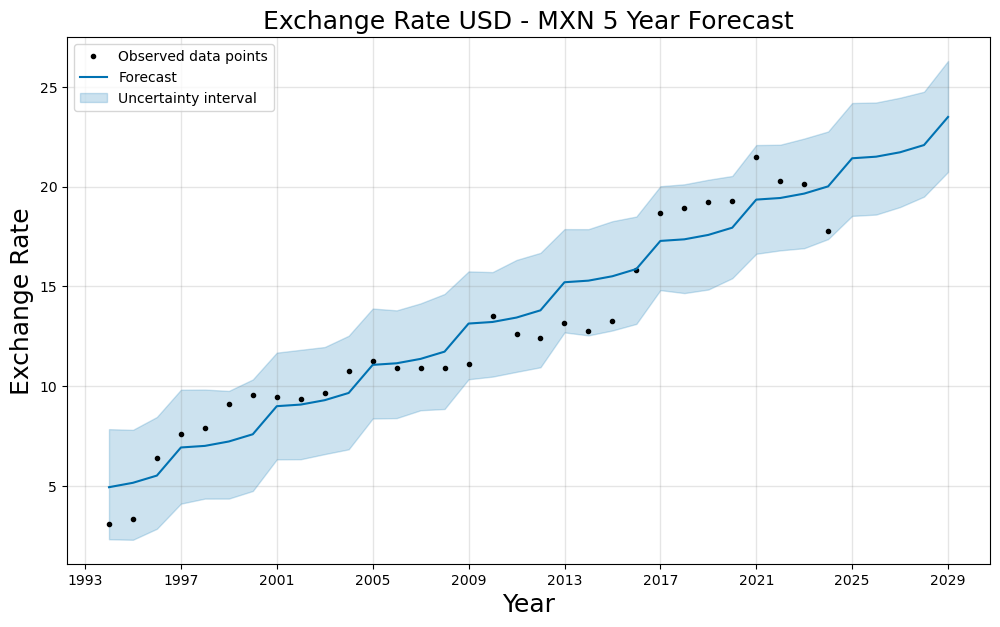

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast)
    plt.legend(loc='upper left')
    plt.title("Exchange Rate USD - MXN {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Exchange Rate' , fontsize=18)

#### Análisis de Componentes: Tendencia + Estacionalidad

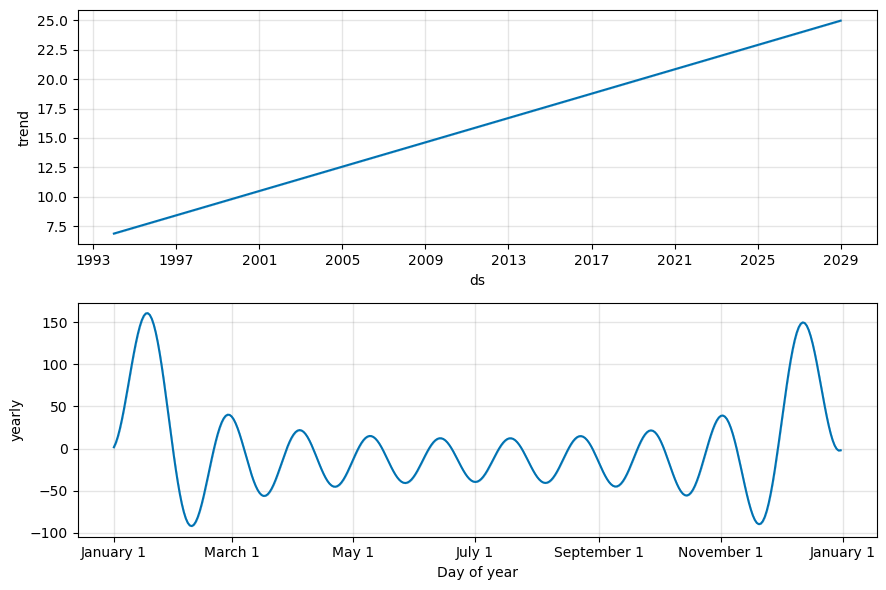

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    fig = model.plot_components(forecast)

### Modelo Serie Temporal Auto-Regresión con Regresores Exógenos

Se utiliza la librería Prophet para entrenar el modelo, incluyendo **regresores exógenos** que consisten en valores anualizados de variables macroeconómicas de México durante los últimos 30 años

El conjunto de datos se obtuvo por medio del **Banco de Datos** del *Banco Mundial* (http://databank.worldbank.org/data/reports.aspx?source=2&series=PA.NUS.FCRF&country=) e incluye la siguiente consulta sobre indicadores macroeconómicos anualizados de México de los últimos **30 años**:

- Official exchange rate (LCU per US$, period average)
- GDP growth (annual %)
- Inflation, consumer prices (annual %)
- Current account balance (% of GDP)
- Unemployment, total (% of total labor force) (national estimate)
- Lending interest rate (%)

Obtenidos de la base de datos *World Development Indicators* actualizada el 28/Junio/2024


Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.

In [16]:
model = Prophet(interval_width = 0.95)
model.add_regressor('GDP',standardize=True)
model.add_regressor('Inflation',standardize=True)
model.add_regressor('Balance',standardize=True)
model.add_regressor('Unemployment',standardize=True)
model.add_regressor('Interest Rate',standardize=True)
model.add_regressor('Merchandise Trade',standardize=True)
model.fit(mx_df)
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '365 days')
df_cv

09:45:44 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:45:45 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-12-31,12.695957,11.851950,13.491711,13.292450,2014-01-02
1,2015-12-31,14.415313,13.600715,15.152245,15.848267,2015-01-02
2,2016-12-31,16.205715,15.308452,17.101789,18.664058,2016-01-02
3,2017-12-31,17.134499,15.964013,18.273263,18.926517,2017-01-01
4,2018-12-31,18.960211,17.777559,20.168259,19.244342,2018-01-01
5,2019-12-31,17.452931,16.245707,18.611628,19.263633,2019-01-01
6,2020-12-31,20.143149,18.873988,21.407954,21.485608,2020-01-01
7,2021-12-31,19.831063,18.713353,20.960732,20.272408,2020-12-31
8,2022-12-31,22.300680,21.198541,23.347067,20.127350,2021-12-31
9,2023-12-31,16.704678,15.364953,18.068760,17.758717,2022-12-31


#### Métricas de Validación Cruzada

In [17]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,363 days,1.204579,1.097533,1.014723,0.067646,0.067646,0.070301,0.50
1,364 days,3.153538,1.775820,1.586298,0.083790,0.094339,0.088474,0.25
2,365 days,1.957836,1.399227,1.252793,0.062896,0.060918,0.062531,0.50


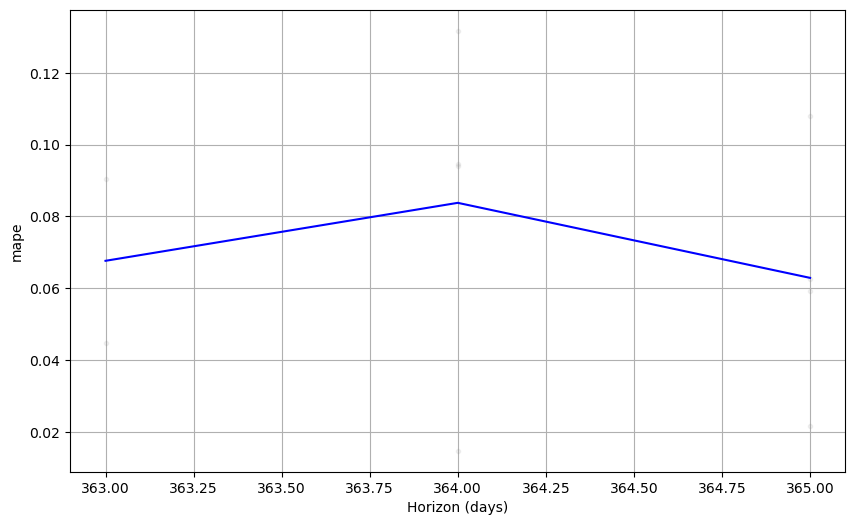

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    fig = plot_cross_validation_metric(df_cv, metric='mape')

Puede observarse que el horizonte de pronóstico con menor error es a **364 días** con un error porcentual del 6.1%

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado.
Para poder hacer el pronóstico, se necesita del **pronóstico de los regresores exógenos** para este horizonte de tiempo. Para ello se utiliza el ***One-Click Report: México*** del Economist Intelligence Unit (EIU) para el 6 de Mayo de 2024 (https://www.eiu.com/n/).

In [19]:
mx_df_ext.rename(columns={'Exchange Rate':'y','Date':'ds'},inplace=True)
mx_df_ext

,Year,GDP,Inflation,Balance,Unemployment,Interest Rate,Merchandise Trade,ds
0,2024,2.3,4.4,-0.4,3.0,11.2,67.89,2024-12-31
1,2025,2.3,3.6,-0.7,3.1,9.9,67.89,2025-12-31
2,2026,2.1,3.3,-1.1,3.3,8.8,67.89,2026-12-31
3,2027,2.2,3.2,-1.3,3.3,7.9,67.89,2027-12-31
4,2028,2.2,3.1,-1.6,3.3,7.6,67.89,2028-12-31


In [20]:
n_forecast = 4
future = pd.concat([mx_df,mx_df_ext],axis=0)
future
forecast_ext = model.predict(future)
forecast_ext.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Balance,Balance_lower,Balance_upper,GDP,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31,2024-12-31,-3.612183,16.715995,19.440834,-3.612331,-3.612017,0.122757,0.122757,0.122757,-0.045235,...,4.365202,4.365202,4.365202,17.325526,17.325526,17.325526,0.0,0.0,0.0,18.078545
32,2025-12-31,-3.549301,16.683771,19.500912,-3.549757,-3.548758,0.086468,0.086468,0.086468,-0.045235,...,4.300649,4.300649,4.300649,17.344259,17.344259,17.344259,0.0,0.0,0.0,18.095607
33,2026-12-31,-3.486419,16.560117,19.382050,-3.487244,-3.485464,0.038083,0.038083,0.038083,-0.006123,...,4.212743,4.212743,4.212743,17.230382,17.230382,17.230382,0.0,0.0,0.0,17.956707
34,2027-12-31,-3.423536,16.420657,19.105933,-3.424815,-3.422113,0.013890,0.013890,0.013890,-0.025679,...,4.194005,4.194005,4.194005,16.984050,16.984050,16.984050,0.0,0.0,0.0,17.754519
35,2028-12-31,-3.360482,16.793611,19.448767,-3.362204,-3.358607,-0.022399,-0.022399,-0.022399,-0.025679,...,4.164901,4.164901,4.164901,17.325526,17.325526,17.325526,0.0,0.0,0.0,18.129945


In [21]:
forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(4)

,ds,yhat,yhat_lower,yhat_upper
32,2025-12-31,18.095607,16.683771,19.500912
33,2026-12-31,17.956707,16.560117,19.382050
34,2027-12-31,17.754519,16.420657,19.105933
35,2028-12-31,18.129945,16.793611,19.448767


<Figure size 1500x700 with 0 Axes>

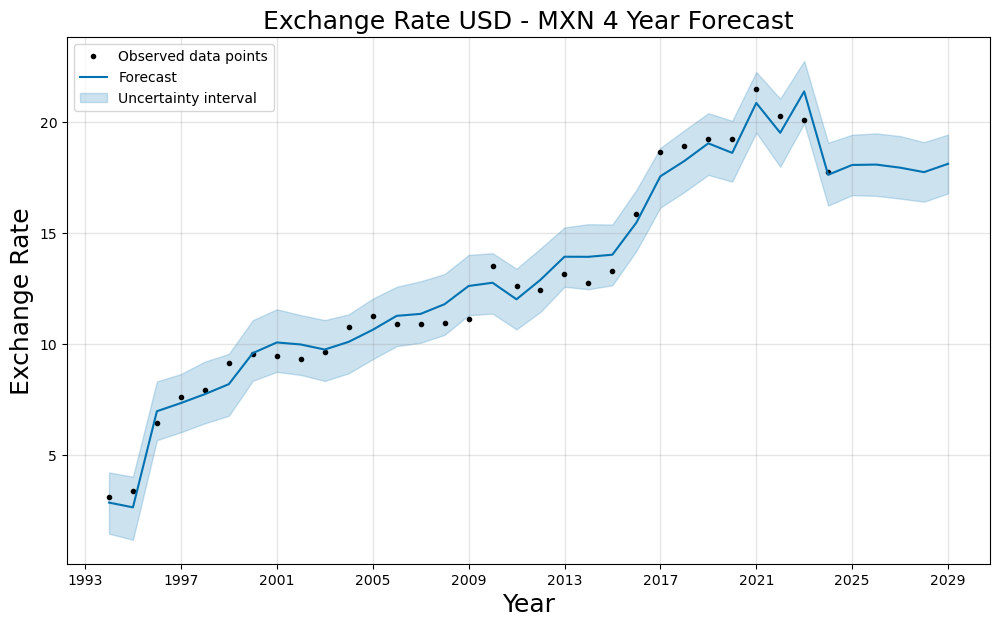

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast_ext)
    plt.legend(loc='upper left')
    plt.title("Exchange Rate USD - MXN {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Exchange Rate' , fontsize=18)

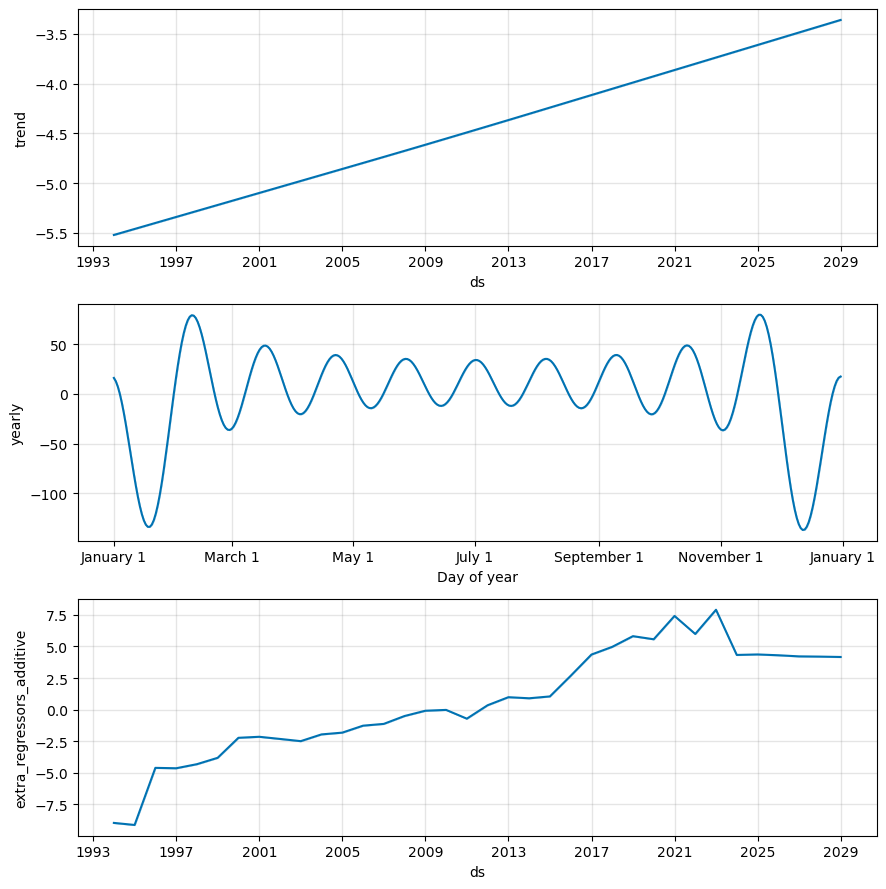

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    model.plot_components(forecast_ext)

### Resumen Resultados

#### OLS Regression


In [24]:
serie_temporal_ols = ex_hat_forecast[['Date','Forecasted Exchange Rate']].copy()


serie_temporal_ols.rename(columns={'Forecasted Exchange Rate':'Tasa','Date':'ds'},inplace=True)
serie_temporal_ols

,ds,Tasa
0,2024-12-31,18.089197
1,2025-12-31,18.217471
2,2026-12-31,18.374439
3,2027-12-31,18.488367
4,2028-12-31,18.616641


#### Serie Temporal Simple

In [25]:
serie_temporal = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal.rename(columns={"yhat": "Tasa", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"},inplace=True)
serie_temporal

,ds,Tasa,LI 95% Confianza,LS 95% Confianza
31,2024-12-31,21.420325,18.533554,24.187863
32,2025-12-31,21.500166,18.600177,24.213713
33,2026-12-31,21.720841,18.976231,24.452432
34,2027-12-31,22.082713,19.498475,24.751816
35,2028-12-31,23.490062,20.736043,26.295345


#### Serie Temporal con Regresores

In [26]:
serie_temporal_reg = forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal_reg.rename(columns={"yhat": "Tasa", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"},inplace=True)
serie_temporal_reg

,ds,Tasa,LI 95% Confianza,LS 95% Confianza
31,2024-12-31,18.078545,16.715995,19.440834
32,2025-12-31,18.095607,16.683771,19.500912
33,2026-12-31,17.956707,16.560117,19.382050
34,2027-12-31,17.754519,16.420657,19.105933
35,2028-12-31,18.129945,16.793611,19.448767


#### Promedio de Ensamble

In [27]:
df_concat = pd.concat((serie_temporal_reg, serie_temporal,serie_temporal_ols))
plt_df = df_concat.groupby('ds').mean()
plt_df

,Tasa,LI 95% Confianza,LS 95% Confianza
ds,,,
2024-12-31,19.196022,17.624775,21.814349
2025-12-31,19.271081,17.641974,21.857313
2026-12-31,19.350662,17.768174,21.917241
2027-12-31,19.441866,17.959566,21.928874
2028-12-31,20.078883,18.764827,22.872056


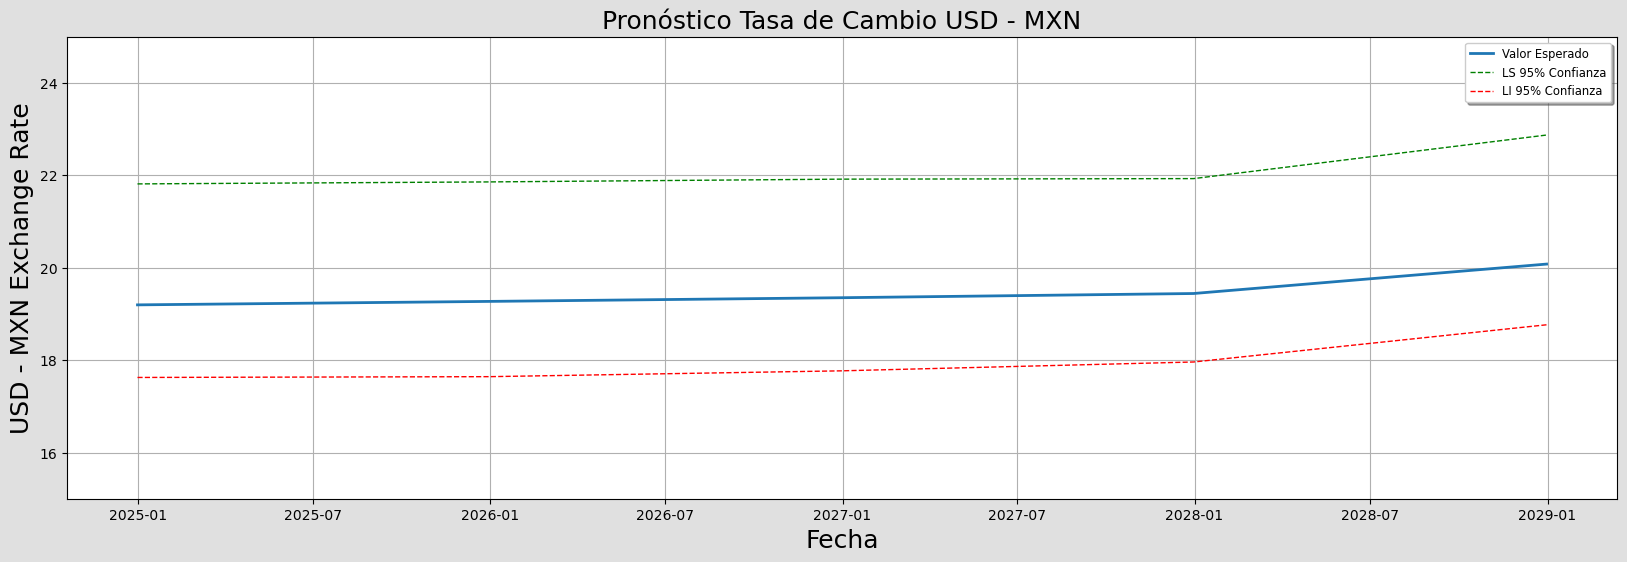

In [28]:
fig, ax = plt.subplots(figsize=(20,6))
plt.ylim(15, 25)
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(plt_df.index,plt_df['Tasa'],linewidth=2, label='Valor Esperado')
ax.plot(plt_df.index,plt_df['LS 95% Confianza'],color='green', linestyle='dashed', linewidth=1,label='LS 95% Confianza')
ax.plot(plt_df.index,plt_df['LI 95% Confianza'],color='red', linestyle='dashed', linewidth=1,label='LI 95% Confianza')
plt.title("Pronóstico Tasa de Cambio USD - MXN" ,  fontsize=18)
plt.xlabel('Fecha' ,  fontsize=18)
plt.ylabel('USD - MXN Exchange Rate' , fontsize=18)
legend = ax.legend(loc='best', shadow=True, fontsize='small')